# Data Analysis
## purpose of this task




### bbc - news categrization
how can it be used? 

1. for categorizing, when you save or write news, then you can just it upload and then this, algorithm could categorize it.
2. furthermore, it can be used with stocks, if it categorize news well then, can classify real news and information for stocks, then it will be used with auto trading system.


### import libraries

In [2]:
import plaidml.keras
import os
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

plaidml.keras.install_backend ()
os.environ ['KERAS_BACKEND'] ='plaidml.keras.backend'


In [3]:
# ignore warnings
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib font err
import platform
from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib as mpl

In [4]:
'C:/Users/Bonghwan/Downloads'
df = pd.read_csv('C:/Users/Bonghwan/Downloads/bbc-text.csv')
df.head(5)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [6]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [7]:
train_size = int(len(df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 1780
Test size: 445


In [12]:
def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

In [13]:
train_cat, test_cat = train_test_split(df['category'], train_size)
train_text, test_text = train_test_split(df['text'], train_size)

In [16]:
import keras
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

In [17]:
tokenize.fit_on_texts(train_text) # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [20]:
from sklearn.preprocessing import LabelEncoder
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

In [21]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [22]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1780, 1000)
x_test shape: (445, 1000)
y_train shape: (1780, 5)
y_test shape: (445, 5)


###  Train the model

In [24]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2
drop_ratio = 0.5

In [28]:
#  Build the model

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models

model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
# model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 515,077
Trainable params: 515,077
Non-trainable params: 0
_________________________________________________________________


In [31]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/2
51/51 [==============================] - 0s 3ms/step - loss: 0.4460 - accuracy: 0.8658 - val_loss: 0.1754 - val_accuracy: 0.9326
Epoch 2/2
51/51 [==============================] - 0s 2ms/step - loss: 0.0549 - accuracy: 0.9863 - val_loss: 0.1221 - val_accuracy: 0.9494


In [32]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

14/14 [==============================] - 0s 644us/step - loss: 0.1459 - accuracy: 0.9528
Test loss: 0.14594382047653198
Test accuracy: 0.9528089761734009


### Hyperparameter tuning
This is a good time to go back and tweak some parameters such as epoch, batch size, dropout ratio, network structure, activation function, and others, to see if you can improve the accuracy.

In this particular case, to make it more challenging, I recommend reducing the max words of the call to keras.preprocessing.text.Tokenizer. This will reduce the number of words for each input sample, thus making it more challenging to accurately predict the category. (Notice that not all hyperparameters are necessarily inside the model. This is one such example.)

The default was up to 1000 words per article. See what happens when you reduce that number to 200 words, or 50 words, or even fewer. As the evaluation accuracy drops, the effects of your hyperparameter tuning will be more pronounced, with successful adjustments making meaningful improvements to the model performance.

To make this process easier to manage, I've encapulated the model definition and training and evaluation calls into one function call. You can add additional parameters as needed.

In [33]:
def run_experiment(batch_size, epochs, drop_ratio):
  print('batch size: {}, epochs: {}, drop_ratio: {}'.format(
      batch_size, epochs, drop_ratio))
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(max_words,)))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(drop_ratio))
  model.add(layers.Dense(num_classes))
  model.add(layers.Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1)
  score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=0)
  print('\tTest loss:', score[0])
  print('\tTest accuracy:', score[1])

In [34]:
batch_size = 16
epochs = 4
drop_ratio = 0.4
run_experiment(batch_size, epochs, drop_ratio)

batch size: 16, epochs: 4, drop_ratio: 0.4
	Test loss: 0.1237570270895958
	Test accuracy: 0.9550561904907227


### Hyperparameter Search
You can also automate this process using for-loops and more sophiscated methods of deciding which combinations of hyperparameter values to try out.

Exhaustive search is generally not the most elegant way, this is mostly just for illustrative purposes.

In [35]:
# Note: The data processed for this output had the max text length set to 400.
# for batch_size in range(10,31,10):
#   for epochs in range(3,15,5):
#     for drop_ratio in np.linspace(0.1, 0.5, 3):
#       run_experiment(batch_size, epochs, drop_ratio)

### Make some predictions
Take some samples from the test dataset and inspect some individual predictions, to ensure that things are sensible.

In [36]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_text.iloc[i][:50], "...")
    print('Actual label:' + test_cat.iloc[i])
    print("Predicted label: " + predicted_label + "\n")  

hobbit picture  four years away  lord of the rings ...
Actual label:entertainment
Predicted label: entertainment

game firm holds  cast  auditions video game firm b ...
Actual label:tech
Predicted label: sport

clarke plans migrant point scheme anyone planning  ...
Actual label:politics
Predicted label: politics

radcliffe will compete in london paula radcliffe w ...
Actual label:sport
Predicted label: sport

serena becomes world number two serena williams ha ...
Actual label:sport
Predicted label: sport

ultimate game  award for doom 3 sci-fi shooter doo ...
Actual label:tech
Predicted label: tech

algeria hit by further gas riots algeria suffered  ...
Actual label:business
Predicted label: business

fast lifts rise into record books two high-speed l ...
Actual label:tech
Predicted label: business

muslim group attacks tv drama 24 a british muslim  ...
Actual label:entertainment
Predicted label: entertainment

us tv special for tsunami relief a us television n ...
Actual label:enterta

### (optional) Extra extra! Visualize the confusion matrix
This can help identify which areas were a challenge to get right, if the model is performing poorly.

In [37]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [38]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

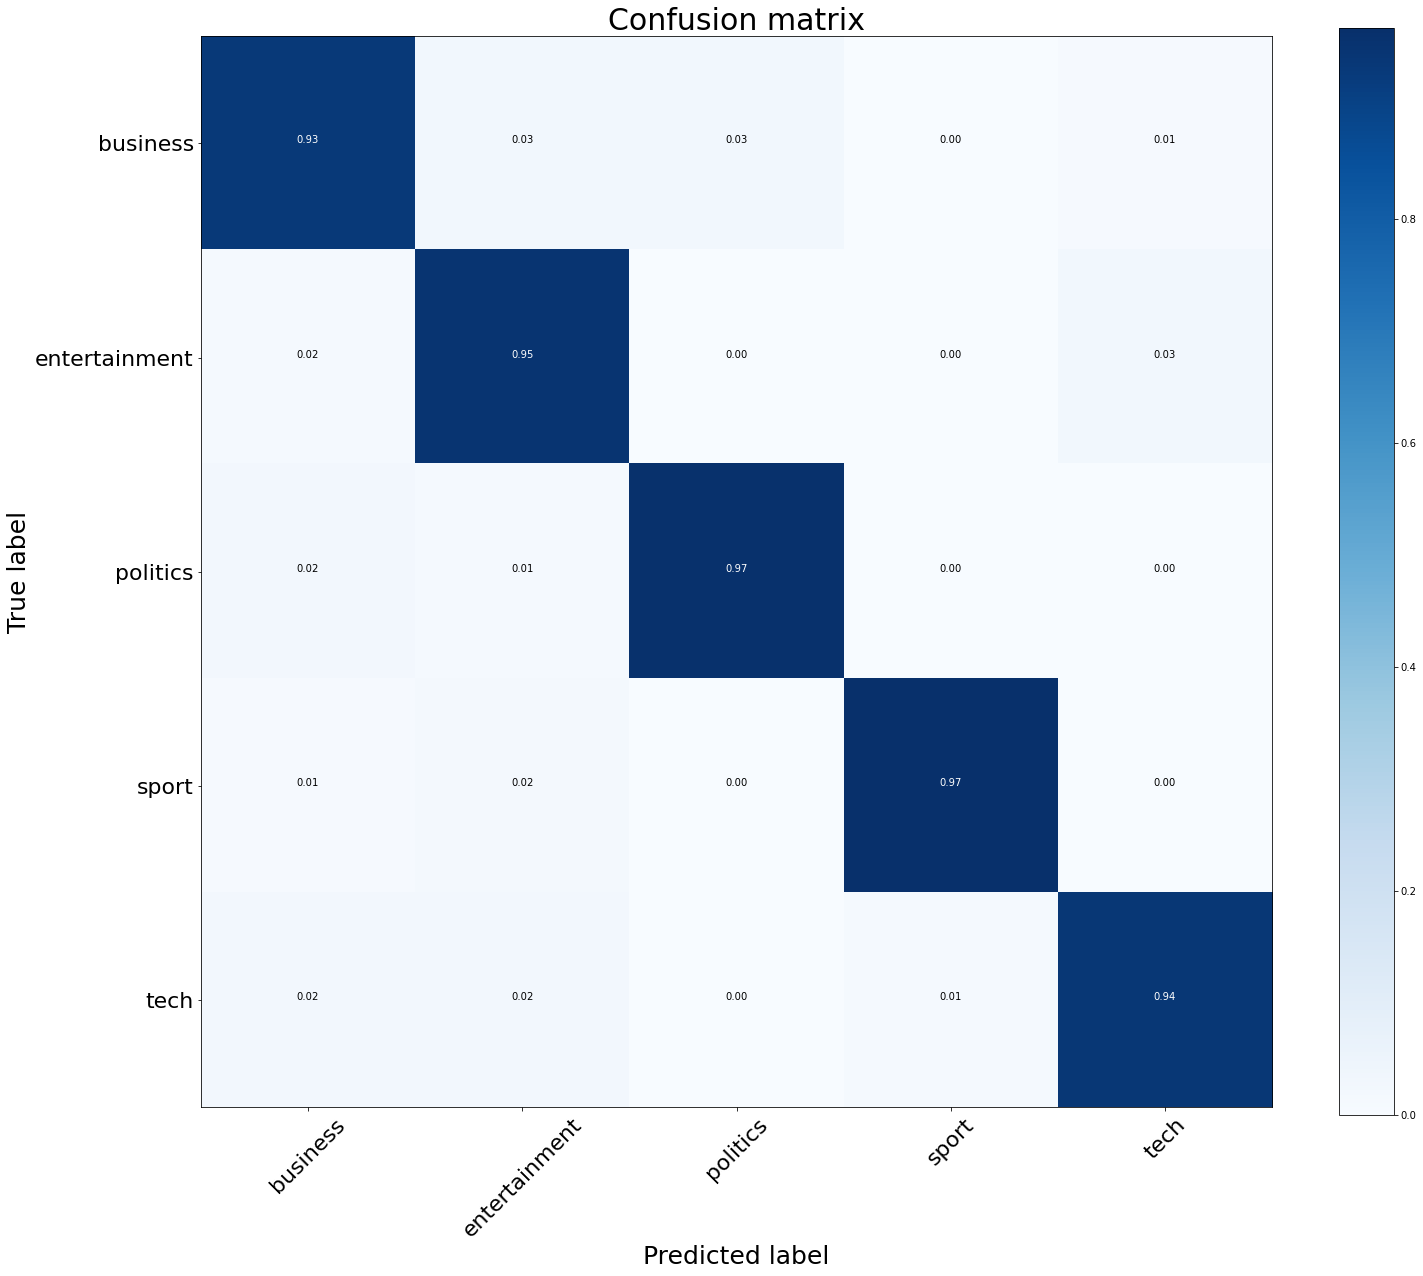

In [40]:
import itertools
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()